# The Exploration of Daniel Bourke's Youtube Channel - My First Data Project

## Introduction
In this notebook, we are going to explore [Daniel Bourke's YouTube channel](https://www.youtube.com/channel/UCr8O8l5cCX85Oem1d18EezQ "mrdbourke").

Daniel Bourke is a machine learning engineer and content creator.

I came across an idea for this when I was browsing his YouTube channel. I noticed that he had two distinct topics: machine learning and fitness.

Then, the thought came to me.

I wonder how the popularity of his machine learning videos would compared to his fitness related videos. And so begins this project.

As with any project, this is a learning oppourtunity to improve my skills in coding and dealing with data. This being my first means I have lots to learn!

## Aims
- Pull data from YouTube Data API v3 to get upload playlist and the individual video statistics for Daniel Bourke's youtube channel.
- Classify his videos between machine learning and fitness/health - somehow.
- Come up with some way of visualising the difference in popularity (based on view count)

## Resources

- [Setting up Google API Client](https://developers.google.com/docs/api/quickstart/python)
- [Google Console](https://console.developers.google.com/)
- [YouTube Data API v3 Documentation](https://developers.google.com/youtube/v3)

## Let's Get Started

Most libraries are the stock standard, included in the Anaconda distribution.

You will need to install the [Google API Client library for Python](https://developers.google.com/docs/api/quickstart/python).

This can be done simply using `pip install google-api-python-client`



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as r
import seaborn as sns

%matplotlib inline

import os
import requests
import math
import re

from datetime import date, time, datetime

import googleapiclient.discovery
import googleapiclient.errors



## Access the YouTube API

You will need to head over to the [Google Console to create a project](https://console.developers.google.com/).

This will give you an API key. Make sure you copy this. I have created a seperate Python file, `setAPIkey.py` that saves the API key to an environment variable, `YT_API`. This file sits in `.gitignore` so it doesn't accidently appear on my github!

Here is the code for `setAPIkey.py`:
```python
#!python3

import os
os.environ['YT_API'] = 'xxAPI KEY HERExx'
```



In [2]:
%run setAPIkey.py
API_KEY = os.getenv('YT_API')

api_service_name = 'youtube'
api_version = 'v3'
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=API_KEY)



## Access the Daniel Bourke's Channel

We are going to access the upload playlist ID which contains all uploaded videos on Daniel Bourke's channel. We do this by using the `channels().list()` method.

This is going to be stored in `uploadPlaylist_ID`

[More documentation on this method, here.](https://developers.google.com/youtube/v3/docs/channels/list)



In [3]:
channel_ID = 'UCr8O8l5cCX85Oem1d18EezQ' # Daniel Bourke's channel ID

channel_request = youtube.channels().list(
    part='snippet,contentDetails',
    id=channel_ID
)
channel_res = channel_request.execute()
channel_res

{'kind': 'youtube#channelListResponse',
 'etag': 'bnXSKtpA6zLxi17N7iPfCfgZkR0',
 'pageInfo': {'resultsPerPage': 1},
 'items': [{'kind': 'youtube#channel',
   'etag': 'hn79H0m-K3PIGztc7HX-w1XdZQo',
   'id': 'UCr8O8l5cCX85Oem1d18EezQ',
   'snippet': {'title': 'Daniel Bourke',
    'description': "I'm a machine learning engineer who plays at the intersection of technology and health.\n\nMy videos will help you learn better and live healthier.\n\nFeel free to introduce yourself, I'd love to hear from you.\n\nDaniel",
    'publishedAt': '2016-08-02T21:36:26Z',
    'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxNt1Rdz4=s88-c-k-c0xffffffff-no-rj-mo',
      'width': 88,
      'height': 88},
     'medium': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxNt1Rdz4=s240-c-k-c0xffffffff-no-rj-mo',
      'width': 240,
      'height': 240},
     'high': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxN

In [4]:
uploadPlaylist_ID = channel_res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

## Get the list of Video IDs

Precisely as the title says, let's get those video IDs in a list. We are going to use a similiar method, `playlistItems().list()`. [More information, here](https://developers.google.com/youtube/v3/docs/playlistItems/list)

We can request 50 video IDs at a time. A `pageToken` variable is given that allows us to access the next lot of 50 videos. I'm going to write this as a funciton and call it `playlist_requester()` since I will be calling it multiple times.

In [5]:
def playlist_requester(pageToken=None,uploadPlaylist_ID=uploadPlaylist_ID):
    playlist_request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        maxResults=50,
        pageToken=pageToken,
        playlistId=uploadPlaylist_ID
    )
    playlist_res = playlist_request.execute()
    
    return playlist_res



I run the function once to get the total number of videos in this playlist and the first pageToken variable.

What I also do is create a list of just the video IDs, which is the only thing relevant. I use a list comprehension to do this.



In [6]:
playlist_res = playlist_requester()

TOTAL_UPLOADS = playlist_res['pageInfo']['totalResults'] # total videos in upload playslist
nextPageToken = playlist_res['nextPageToken'] # needed to access the next page

listOfVideo_IDs = [ video_ID['contentDetails']['videoId'] for video_ID in playlist_res['items'] ] # first 50



Then, I create a while loop to get all the video IDs into a list.



In [7]:
while TOTAL_UPLOADS > len(listOfVideo_IDs):
    
    nextpage_playlist_res = playlist_requester(nextPageToken)
    listOfVideo_IDs.extend([ video_ID['contentDetails']['videoId'] for video_ID in nextpage_playlist_res['items'] 
                            if video_ID['contentDetails']['videoId'] not in listOfVideo_IDs ]) # extend() for lists / #append only does one item at ta time / concating lists with + is very intenstive according to "Python for Data Analysis"
    if 'nextPageToken' in nextpage_playlist_res:
        nextPageToken = nextpage_playlist_res['nextPageToken']
        
    print('Number of Uploaded Videos: ' + str(len(listOfVideo_IDs)))

Number of Uploaded Videos: 100
Number of Uploaded Videos: 150
Number of Uploaded Videos: 200
Number of Uploaded Videos: 250
Number of Uploaded Videos: 252


## Get the Video Statistics

What we finally waited for. Time to finally get all the video statistic's data.

In [8]:
df = pd.DataFrame()

for i in range(math.ceil(len(listOfVideo_IDs)/50)):
    video_request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        id=listOfVideo_IDs[50*i:50*(i+1)]
    )
    video_response = video_request.execute()

    sub_df = pd.json_normalize(video_response, 'items')
    frames = [df, sub_df]
    df = pd.concat(frames)

In [9]:
df.head(2)

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.favoriteCount,statistics.commentCount,snippet.tags,snippet.defaultAudioLanguage,contentDetails.regionRestriction.blocked
0,youtube#video,zBcwkM8SFqDdtRJhv8FjTjNalJQ,Nz7xzUybpFM,2020-09-06T10:58:18Z,UCr8O8l5cCX85Oem1d18EezQ,Building a Deep Learning PC,I've been thinking about building my own deep ...,https://i.ytimg.com/vi/Nz7xzUybpFM/default.jpg,120,90,...,False,rectangular,3557,206,5,0,89,NaN,NaN,NaN
1,youtube#video,axuuWsG0acKF4jznc1Axr7WKOn4,3IKWukTiBfc,2020-08-09T06:06:03Z,UCr8O8l5cCX85Oem1d18EezQ,The future will not be supervised... | Machine...,This month has been all about GPT3 and self-su...,https://i.ytimg.com/vi/3IKWukTiBfc/default.jpg,120,90,...,True,rectangular,7261,275,2,0,36,"[self supervised learning machine learning, ma...",NaN,NaN


In [10]:
#checking dataframe
df.shape

(252, 41)

In [11]:
#exploring different columns
df.dtypes

kind                                         object
etag                                         object
id                                           object
snippet.publishedAt                          object
snippet.channelId                            object
snippet.title                                object
snippet.description                          object
snippet.thumbnails.default.url               object
snippet.thumbnails.default.width              int64
snippet.thumbnails.default.height             int64
snippet.thumbnails.medium.url                object
snippet.thumbnails.medium.width               int64
snippet.thumbnails.medium.height              int64
snippet.thumbnails.high.url                  object
snippet.thumbnails.high.width                 int64
snippet.thumbnails.high.height                int64
snippet.thumbnails.standard.url              object
snippet.thumbnails.standard.width           float64
snippet.thumbnails.standard.height          float64
snippet.thum

In [12]:
# contining with most relavant columns
df1 = df[['snippet.title', 'snippet.tags', 'contentDetails.duration',
       'statistics.viewCount', 'statistics.likeCount', 'statistics.dislikeCount',
        'statistics.commentCount', 'snippet.publishedAt']]
#df1.ix['statistics.viewCount'] = df1['statistics.viewCount'].astype('int')
#df1.head()
df1 = df1.astype({'statistics.viewCount': 'float'})
df1 = df1.astype({'statistics.likeCount': 'float'})
df1 = df1.astype({'statistics.dislikeCount': 'float'})
df1 = df1.astype({'statistics.commentCount': 'float'})
# df1.astype().dtypes
df1.dtypes

snippet.title               object
snippet.tags                object
contentDetails.duration     object
statistics.viewCount       float64
statistics.likeCount       float64
statistics.dislikeCount    float64
statistics.commentCount    float64
snippet.publishedAt         object
dtype: object

In [13]:
# analysing tags 
tagsds = df['snippet.tags']
tagsds

0                                                   NaN
1     [self supervised learning machine learning, ma...
2                                                   NaN
3     [ken jee, daniel bourke, what questions get as...
4     [machine learning field guide, machine learnin...
                            ...                        
47    [udacity, coding, python, programming, ai, art...
48    [workout music 2016, workout motivation, worko...
49    [cooking, recipes, vegetarian, snacks, protein...
0     [DIY, fitness, exercise, pullupbar, snapchat, ...
1     [xbox, xboxone, gaming, mlg, microsoft, xboxon...
Name: snippet.tags, Length: 252, dtype: object

In [14]:
s = tagsds.apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [15]:
s

daniel bourke                                       95
fitness                                             58
machine learning engineer                           56
learning                                            52
vlog                                                51
                                                    ..
short term                                           1
google cloud data engineering on coursera review     1
nanowrimo 2017                                       1
andrew ng coursera                                   1
of code                                              1
Length: 1687, dtype: int64

In [16]:
s[lambda x : x > 10].head(50)

daniel bourke                                 95
fitness                                       58
machine learning engineer                     56
learning                                      52
vlog                                          51
life                                          51
podcast                                       51
machine                                       49
lessons                                       49
entertainment                                 49
Daniel Bourke                                 48
The Daniel Bourke Show                        47
college                                       47
success                                       47
university                                    47
fail                                          47
Show                                          46
public                                        46
The                                           46
Daniel                                        46
speaking            

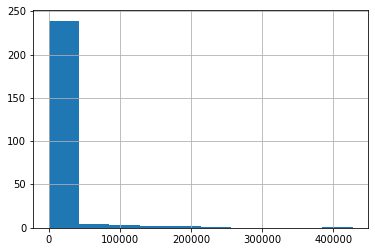

In [17]:
x = df1['statistics.viewCount']
x.hist()

In [18]:
x.max()

427303.0

In [19]:
isML = tagsds.str.contains(pat='machine learning', regex=False)
isML

0       NaN
1      True
2       NaN
3     False
4     False
      ...  
47     True
48    False
49    False
0     False
1     False
Name: snippet.tags, Length: 252, dtype: object

In [20]:
MLdf = df1[isML==True]
notMLdf = df1[isML==False]
MLdf['statistics.viewCount_NLOG'] = np.log(MLdf['statistics.viewCount'])
notMLdf['statistics.viewCount_NLOG'] = np.log(notMLdf['statistics.viewCount'])
notMLdf.head()

C:\Users\Shiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Shiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,statistics.viewCount_NLOG
3,What does a head of data science look for in a...,"[ken jee, daniel bourke, what questions get as...",PT1H1M6S,9205.0,453.0,8.0,34.0,2020-07-16T03:15:13Z,9.127502
4,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,239150.0,12595.0,146.0,528.0,2020-07-12T15:00:12Z,12.384846
5,One Neural Network to Rule Them All (and more)...,"[zero to mastery, machine learning monthly, wh...",PT32M2S,5521.0,198.0,0.0,62.0,2020-07-06T10:30:06Z,8.616314
8,How to be more self-reliant: The Jester Physic...,"[how to be more self-reliant, the four pillars...",PT22M1S,2462.0,99.0,3.0,40.0,2020-05-31T13:15:01Z,7.808729
10,Upgrade your decision making using these 4 boxes,"[decision making, how to make better decisions...",PT24M13S,3654.0,123.0,6.0,50.0,2020-05-16T13:00:05Z,8.203578


In [21]:
(isML==False).sum() + (isML==True).sum() + 13 # drops NaN

251

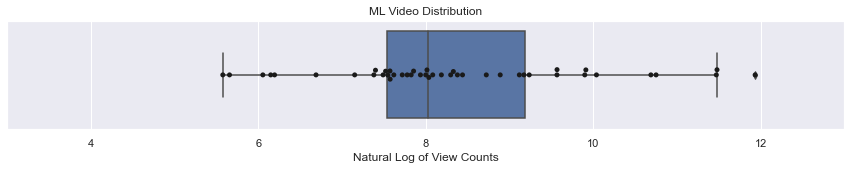

In [22]:
data = MLdf

sns.set(style='darkgrid')
plt.figure(figsize=(15,2))
ax = sns.boxplot(x='statistics.viewCount_NLOG', data=data, orient='h')
ax = sns.swarmplot(x='statistics.viewCount_NLOG', data=data, orient='h', color='0.1')
ax.set(xlim=(3,13))

ax.set(xlabel='Natural Log of View Counts', title='ML Video Distribution', )
plt.show()

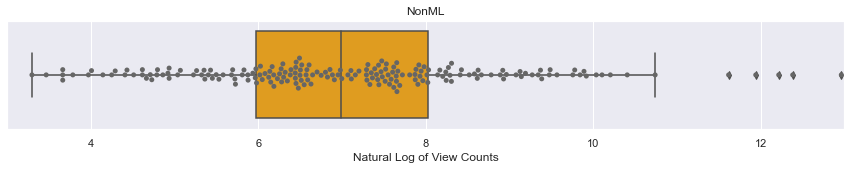

In [23]:
data = notMLdf

sns.set(style='darkgrid')
plt.figure(figsize=(15,2))
ax = sns.boxplot(x='statistics.viewCount_NLOG', data=data, orient='h', color='orange')
ax = sns.swarmplot(x='statistics.viewCount_NLOG', data=data, orient='h',color='0.4')
ax.set(xlim=(3,13))

ax.set(xlabel='Natural Log of View Counts', title='NonML', )
plt.show()

In [24]:
#checking out 5 most popular videos for each group
MLdf.sort_values(by='statistics.viewCount', ascending=False).head()

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,statistics.viewCount_NLOG
23,A Day In The Life Of A Machine Learning Engine...,"[machine learning engineer, a day in the life ...",PT9M7S,152655.0,1819.0,384.0,178.0,2018-07-21T14:32:52Z,11.935936
19,5 Beginner Friendly Steps to Learn Machine Lea...,"[how to learn machine learning with python, ho...",PT13M42S,96800.0,5801.0,47.0,354.0,2019-09-15T12:00:59Z,11.480402
21,These books will help you learn machine learning,"[the best books for machine learning, best boo...",PT10M23S,96015.0,4398.0,29.0,198.0,2019-08-18T10:04:03Z,11.472260
2,Code with me (live): How to make your first Ka...,"[machine learning engineer kaggle, kaggle data...",PT2H5M45S,46729.0,1133.0,8.0,140.0,2018-12-02T05:03:43Z,10.752120
39,Self-Studying Machine Learning? Remind yoursel...,"[machine learning study tips, machine learning...",PT13M53S,43933.0,1759.0,17.0,164.0,2019-03-02T22:23:30Z,10.690421


In [25]:
notMLdf.sort_values(by='statistics.viewCount', ascending=False).head()

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,statistics.viewCount_NLOG
18,"I didn't eat food for 4 days, here's what happ...","[what is like to do an extended fast?, intermi...",PT45M41S,427303.0,4914.0,491.0,937.0,2019-09-15T12:06:12Z,12.965249
4,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,239150.0,12595.0,146.0,528.0,2020-07-12T15:00:12Z,12.384846
36,How I got Google Cloud Professional Data Engin...,"[google cloud, google cloud professional data ...",PT20M,202382.0,4330.0,158.0,313.0,2019-04-27T12:20:52Z,12.217912
33,Don't learn machine learning,"[machine learning engineer, how to learn machi...",PT17M57S,153789.0,3477.0,397.0,294.0,2020-03-30T04:23:56Z,11.943337
13,I got my machine learning model deployed! | Ai...,"[machine learning project, what does a machine...",PT22M21S,111204.0,2048.0,38.0,136.0,2020-04-16T13:00:27Z,11.619122


In [26]:
df1.sort_values(by='statistics.viewCount', ascending=False).head(10)

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt
18,"I didn't eat food for 4 days, here's what happ...","[what is like to do an extended fast?, intermi...",PT45M41S,427303.0,4914.0,491.0,937.0,2019-09-15T12:06:12Z
4,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,239150.0,12595.0,146.0,528.0,2020-07-12T15:00:12Z
7,How I passed the TensorFlow Developer Certific...,NaN,PT26M25S,207938.0,7361.0,88.0,522.0,2020-06-10T02:06:17Z
36,How I got Google Cloud Professional Data Engin...,"[google cloud, google cloud professional data ...",PT20M,202382.0,4330.0,158.0,313.0,2019-04-27T12:20:52Z
33,Don't learn machine learning,"[machine learning engineer, how to learn machi...",PT17M57S,153789.0,3477.0,397.0,294.0,2020-03-30T04:23:56Z
23,A Day In The Life Of A Machine Learning Engine...,"[machine learning engineer, a day in the life ...",PT9M7S,152655.0,1819.0,384.0,178.0,2018-07-21T14:32:52Z
13,I got my machine learning model deployed! | Ai...,"[machine learning project, what does a machine...",PT22M21S,111204.0,2048.0,38.0,136.0,2020-04-16T13:00:27Z
19,5 Beginner Friendly Steps to Learn Machine Lea...,"[how to learn machine learning with python, ho...",PT13M42S,96800.0,5801.0,47.0,354.0,2019-09-15T12:00:59Z
21,These books will help you learn machine learning,"[the best books for machine learning, best boo...",PT10M23S,96015.0,4398.0,29.0,198.0,2019-08-18T10:04:03Z
6,How to get experience as a beginner data scien...,NaN,PT27M56S,48293.0,1770.0,16.0,189.0,2020-07-05T06:57:22Z


In [27]:
test = pd.get_dummies(df1['snippet.tags'].apply(pd.Series).stack())
test

10-minute bodyweight workout  10-minute morning workout routine  100  \
1 0                              0                                  0    0   
  1                              0                                  0    0   
  2                              0                                  0    0   
  3                              0                                  0    0   
  4                              0                                  0    0   
...                            ...                                ...  ...   
  9                              0                                  0    0   
  10                             0                                  0    0   
  11                             0                                  0    0   
  12                             0                                  0    0   
  13                             0                                  0    0   

      100 Days of ML Code vlog  100 days  100 days of code  \
1 0                          0         0                 0   
  1                          0         0                 0   
  2                          0         0                 0   
  3                          0         0                 0   
  4                          0         0                 0   
...                        ...       ...               ...   
  9                          0         0                 0   
  10                         0         0                 0   
  11                         0         0                 0   
  12                         0         0                 0   
  13                         0         0                 0   

      100 days of code vlog  100 days of code vlog series  100 days of coding  \
1 0                       0                             0                   0   
  1                       0                             0                   0   
  2                       0                             0                   0   
  3                       0                             0                   0   
  4                       0                             0                   0   
...                     ...                           ...                 ...   
  9                       0                             0                   0   
  10                      0                             0                   0   
  11                      0                             0                   0   
  12                      0                             0                   0   
  13                      0                             0                   0   

      100 days of ml code  ...  young starters  your  youtube  \
1 0                     0  ...               0     0        0   
  1                     0  ...               0     0        0   
  2                     0  ...               0     0        0   
  3                     0  ...               0     0        0   
  4                     0  ...               0     0        0   
...                   ...  ...             ...   ...      ...   
  9                     0  ...               0     0        0   
  10                    0  ...               0     0        0   
  11                    0  ...               0     0        0   
  12                    0  ...               0     0        0   
  13                    0  ...               0     0        0   

      youtube livestream  youtube trailer  \
1 0                    0                0   
  1                    0                0   
  2                    0                0   
  3                    0                0   
  4                    0                0   
...                  ...              ...   
  9                    0                0   
  10                   0                0   
  11                   0                0   
  12                   0                0   
  13                   0                0   

      youtubes fittest machin

In [28]:
df1.head()

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt
0,Building a Deep Learning PC,NaN,PT1H1M46S,3557.0,206.0,5.0,89.0,2020-09-06T10:58:18Z
1,The future will not be supervised... | Machine...,"[self supervised learning machine learning, ma...",PT26M28S,7261.0,275.0,2.0,36.0,2020-08-09T06:06:03Z
2,Are courses enough for a job? | Machine learni...,NaN,PT1H24M11S,7159.0,305.0,9.0,26.0,2020-08-06T00:29:48Z
3,What does a head of data science look for in a...,"[ken jee, daniel bourke, what questions get as...",PT1H1M6S,9205.0,453.0,8.0,34.0,2020-07-16T03:15:13Z
4,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,239150.0,12595.0,146.0,528.0,2020-07-12T15:00:12Z


In [29]:
df1['snippet.publishedAt']

0     2020-09-06T10:58:18Z
1     2020-08-09T06:06:03Z
2     2020-08-06T00:29:48Z
3     2020-07-16T03:15:13Z
4     2020-07-12T15:00:12Z
              ...         
47    2017-03-25T02:05:17Z
48    2017-03-17T13:03:56Z
49    2016-09-07T04:51:40Z
0     2016-08-08T03:45:09Z
1     2016-08-03T05:22:01Z
Name: snippet.publishedAt, Length: 252, dtype: object